In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.ops as ops
import torch.nn.functional as fn
from PIL import Image
from torch.utils.data import Dataset
import os
import math
from natsort import natsorted
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

batchsize = 4
desiredImageSideLength = 256
gridSize = 8
numberOfClasses = 14
cellSize = desiredImageSideLength/gridSize

#Custom Dataset for the specialized task of the assignment: multi-label, multi-class object detection
class ObjectDetectionDataSet(Dataset):
    def __init__(self, root, transform):
        self.main_dir = root
        self.img_dir = os.path.join(self.main_dir, 'images')
        self.json_dir = os.path.join(self.main_dir, 'annotations')
        self.transform = transform
        all_imgs = os.listdir(self.img_dir)
        self.total_imgs = natsorted(all_imgs)
        all_json = os.listdir(self.json_dir)
        self.total_json = natsorted(all_json)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        #Image path
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        #Load Image
        image = Image.open(img_loc).convert("RGB")
        #Get size for resizing boxes keeping the ratio
        imageWidth , imageHeigth = image.size
        #Apply transformation (Tensorization, Resizing, Normalization) 
        image = self.transform(image)
        #Calculating aspect ratio of image
        ratio = torch.tensor([desiredImageSideLength/imageWidth, desiredImageSideLength/imageHeigth,desiredImageSideLength/imageWidth, desiredImageSideLength/imageHeigth])

        #JSON Annotation file path
        json_loc = os.path.join(self.json_dir, self.total_json[idx])
        #Open and load JSON file
        f = open(json_loc)
        jsonf = json.load(f)
        #Each file has (number of item + 2) keys, then we deduce the number of labels for the sample
        label_number = len(jsonf.keys())-2
            #print(f"Number of items: {label_number}")
        #The label tensor for the image is organized as follows
        # 0-3 for the bounding box coordinates (x,y,w,h)
        # 4-numberOfClasses+1 for the one-hot vector used in the classification task
        label = torch.zeros((label_number, numberOfClasses+4+1))
        #Iterate through the items to populate the label tensor
        for i in range(1,label_number+1):
            #Get the bounding boxes coordinates from the annotation file
                #print(jsonf['item'+str(i)]['bounding_box'])
            x_min, y_min, x_max, y_max = np.multiply(jsonf['item'+str(i)]['bounding_box'],ratio)
                #print(f"Xmin: {x_min:.3f}\t Ymin: {y_min:.3f}\tXmax: {x_max:.3f}\tYmax: {y_max:.3f}")
            #Calculate the centroid position
            centroid_x, centroid_y = ((x_min+x_max)/2, (y_min+y_max)/2)
                #print(f"Centroid: ({centroid_x},{centroid_y})")
            #Calculate the height and width of the bounding box 
            bbox_w, bbox_h = ((abs(x_max-x_min)), (abs(y_max-y_min)))
            #Create a one-hot vector which is active for the class of the target
            class_one_hot = fn.one_hot(torch.tensor([jsonf['item'+str(i)]['category_id']]), numberOfClasses+1)[0]
            #Put together the label vector
            box_tensor = torch.tensor([centroid_x,centroid_y,bbox_w,bbox_h])
            item_label = torch.cat((box_tensor,class_one_hot))
            label[i-1] = item_label
        return image, label

#We need to define a new collate function that allows us to have different length tensor for each sample in the batch.
#This is needed because samples have different amount of boxes/classes to detect
def collate_fn(batch):
    image_batch = torch.empty(batchsize,3,256,256)
    label_batch = []
    i = 0
    for (image, label) in batch:
        image_batch[i] = image
        label_batch.append(label)
        i+=1
    return image_batch, label_batch

In [2]:
transformation = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size=(desiredImageSideLength,desiredImageSideLength)),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])
train_dataset = ObjectDetectionDataSet(root='C:\\Users\\pietr\\Downloads\\assignment_1\\assignment_1\\train', transform = transformation)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=0, collate_fn = collate_fn)
test_dataset = ObjectDetectionDataSet(root='C:\\Users\\pietr\\Downloads\\assignment_1\\assignment_1\\test', transform = transformation)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=False, num_workers=0, collate_fn = collate_fn)

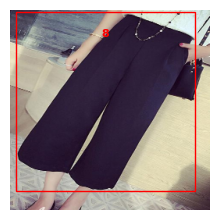

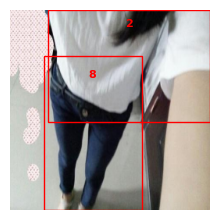

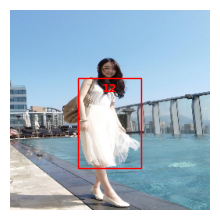

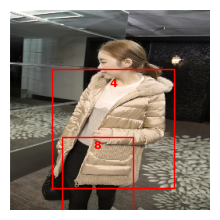

In [3]:
dataiter = iter(trainloader)
images, labels= next(dataiter)
for image, label in zip(images, labels):
  img_unnorm = image/2+0.5
  img_transp = np.transpose(img_unnorm, [1,2,0])
  fig = plt.figure(figsize=(2,2))
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img_transp)
  for i,item in enumerate(label):
    xmin, ymin, w, h = item[0:4]
    box = patches.Rectangle((xmin-w/2, ymin-h/2), w, h, edgecolor = "red", facecolor = "none")
    ax.add_patch(box)
    rx, ry = box.get_xy()
    cx = rx+box.get_width()/2.0
    cy = ry+box.get_height()/8.0
    class_id = torch.argmax(label[i][4:]).item()
    l = ax.annotate(
        class_id,
        (cx, cy),
        fontsize = 8,
        fontweight = "bold",
        color = "red",
        ha = 'center',
        va = 'center'
    )
  plt.axis('off')

In [4]:
import torch.nn as nn

class OutputLayer(nn.Module):
    def __init__(self,nin):
        super().__init__()
        self.output_conv1 = nn.Conv2d(nin, (numberOfClasses+1),kernel_size=3, padding="same")
        self.output_conv2 = nn.Conv2d(nin, 4, kernel_size =3, padding="same")
        self.output_conv2 = nn.ReLU(self.output_conv2)
    def forward(self, x):
        return torch.cat((self.output_conv1(x), self.output_conv2(x)), dim=1)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            OutputLayer(128)
        )

    def forward(self, x):
      return self.model(x)

net = Net()

In [5]:

anchor_boxes = torch.tensor((gridSize,gridSize))
for i in range(0,gridSize):
  for j in range(0,gridSize):
    anchor_boxes[i,j]=torch.tensor([j*cellSize+cellSize/2, i*cellSize+cellSize/2, cellSize, cellSize])

#Function for computing the Jaccard Index (Intersection over Union) of two bounding boxes given in the form xc, yc, w, h
def get_iou_torch(pred, target):
    # Coordinates of the area of intersection.
    ix1 = torch.max(target[0], pred[0])
    iy1 = torch.max(target[1], pred[1])
    ix2 = torch.min(target[2], pred[2])
    iy2 = torch.min(target[3], pred[3])

    # Intersection height and width.
    i_height = torch.max(iy2 - iy1 + 1, torch.tensor(0.))
    i_width = torch.max(ix2 - ix1 + 1, torch.tensor(0.))
    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    target_height = target[3] - target[1] + 1
    target_width = target[2] - target[0] + 1

    # Prediction dimensions.
    pred_height = pred[3] - pred[1] + 1
    pred_width = pred[2] - pred[0] + 1

    area_of_union = target_height * target_width + pred_height * pred_width - area_of_intersection
    iou = area_of_intersection / area_of_union

    return iou

def jaccard(pred_boxes, target_boxes):
    overlaps = torch.tensor((target_boxes.size(0), gridSize*gridSize))
    for i in range(gridSize):
        for j in range(gridSize):
            pred_box = hw_to_corners(pred_boxes[i,j])
            for k in range(target_boxes.size(0)):
                target_box = target_boxes[k]
                overlaps[i,j,k]=get_iou_torch(pred_box,target_box)
    return overlaps

def hw_to_corners(box):
    #Given a box in its (x,y,w,h) form this gives back the same box in the form (x1,y1,x2,y2)
    x1 = box[0]-box[2]/2
    y1 = box[2]-box[3]/2
    x2 = box[0]+box[2]/2
    y2 = box[2]+box[3]/2
    result = [x1,y1,x2,y2]
    return result

def pred_to_bb(pred, anchors):
    #The activation value of the network are mapped to [-1,1]
    pred_bb = torch.tanh(pred)
    #We use the result of the activation to move the center of predicted bounded box up to, This will result in up to 50% of the cellSize
    pred_bb_centers = (pred_bb[:,:2]/2*cellSize)+anchors[:,:2]
    #We do the same thing for the height and width
    pred_bb_hw = (pred_bb[:,2:]/2+1)*anchors[:,2:]
    result = torch.cat(pred_bb_centers,pred_bb_hw, dim=1)
    print(f"Pred_to_bb: {result.shape}")
    return hw_to_corners(result)

def map_to_ground_truth(overlaps):
    prior_overlap, prior_index = overlaps.max(1)
    ground_truth_overlap, ground_truth_index = overlaps.max(0)
    for i, o in enumerate(prior_index): ground_truth_index[o]=1
    return ground_truth_overlap, ground_truth_index


IndexError: too many indices for tensor of dimension 1

In [ ]:
def ssd_single_sample_loss(class_pred, box_pred, class_target, box_target):
    activated_bounded_boxes = pred_to_bb(box_pred, anchor_boxes)
    overlaps = jaccard(activated_bounded_boxes, box_target)
    gt_overlap, gt_index = map_to_ground_truth(overlaps)
    gt_class = class_target[gt_index]
    pos = overlap > 0.4
    pos_index = torch.nonzero(pos)[:,0]
    

In [ ]:
import torch.optim as optim

device = torch.device("cpu")


optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

net = net.to(device)

for epoch in range(3):
  running_loss = 0.0
  for i,batch in enumerate(trainloader):
    batch_images, batch_labels = batch
    batch_images = batch_images.to(device)
    optimizer.zero_grad()
    output = net(batch_images)
    output = output.permute(0,2,3,1)
    
    for j,labels in enumerate(batch_labels):
      overlap = torch.zeros((len(labels),gridSize*gridSize))
      for i, label in enumerate(labels):
        label_box = torch.round(label[0:4]).type(torch.int64).to(device)
        for row in range(0,8):
          for col in range(0,8):
            pred_box = torch.round(output[j][row][col][0:4]).type(torch.int64)
            overlap[i][i*gridSize+j] = get_iou_torch(pred_box, label_box)
      print(overlap)
        
    optimizer.step()
    running_loss += categories_loss.item()#+boxes_loss.item()
    if i % 250 == 249:  # Printing the runnin loss every 500 mini-batches
      print(f"[epoch: {epoch + 1}, mini-batch: {i + 1}] loss: {(running_loss / 250):.3f}")
      running_loss = 0.0
    
    
print('Finished Training')
  

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
dataiter = iter(testloader)
images, category_ids, boxes = next(dataiter)
images = images.to(device)
outputs = net(images)
threshold = 0.3
outputs = outputs.detach().cpu()
print(torch.sigmoid(outputs))
predicted = np.array(outputs > threshold, dtype= float)
predicted = torch.tensor(predicted)
images = images.detach().cpu()
predicted = predicted.detach().cpu()
for img, category, pred in zip(images, category_ids, predicted):
  img_unnorm = img/2 +0.5
  img_transp = np.transpose(img_unnorm, (1,2,0))
  fig = plt.figure(figsize=(2,2))
  plt.imshow(img_transp)
  plt.title(f"Gold: {category}\nPred: {[i for i,value in enumerate(pred) if value ==1]}")
  plt.show